In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

matplotlib.rc("axes", unicode_minus = False)

In [3]:
df1 = pd.read_csv("/home/piai/바탕화면/반도체 공정 프로젝트/B1_반도체/01 Oxidation.csv")
df2 = pd.read_csv("/home/piai/바탕화면/반도체 공정 프로젝트/B1_반도체/02 Photo_softbake.csv")
df3 = pd.read_csv("/home/piai/바탕화면/반도체 공정 프로젝트/B1_반도체/03 Photo_lithograpy.csv")
df4 = pd.read_csv("/home/piai/바탕화면/반도체 공정 프로젝트/B1_반도체/04 Etching.csv")
df5 = pd.read_csv("/home/piai/바탕화면/반도체 공정 프로젝트/B1_반도체/05 Ion_Implantation.csv")
df6 = pd.read_csv("/home/piai/바탕화면/반도체 공정 프로젝트/B1_반도체/06 Inspect.csv")

In [4]:
df = pd.merge(df1, df2, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df3, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df4, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df5, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df6, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])

In [5]:
df.dropna(subset="Thin F2", inplace=True) # 다른 변수들과의 연관성을 찾지못함, 한 행에 여러 열들 결측값 가짐
# pd.set_option('display.max_row', 200)
# pd.set_option('display.max_columns', 200)

In [6]:
df['Ox_Chamber'] = df['Ox_Chamber'].astype('str')
df['photo_soft_Chamber'] = df['photo_soft_Chamber'].astype('str')
df['lithography_Chamber'] = df['lithography_Chamber'].astype('str')
df['Etching_Chamber'] = df['Etching_Chamber'].astype('str')
df['Chamber_Num'] = df['Chamber_Num'].astype('str')
df['path'] = df['Ox_Chamber']+df['photo_soft_Chamber']+df['lithography_Chamber']+df['Etching_Chamber']+df['Chamber_Num']

In [7]:
df.drop(df[df['Oxid_time']<0].index, inplace=True) # 산화시간이 음수
df.drop(df[df['Target']==0].index, inplace=True) # target 값이 0
df.drop(columns = ["Wafer_map","Error_message"],inplace=True) # 웨이퍼맵, 에러메시지

In [8]:
# 시간 데이터 datetime 유형으로 변환
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y')

# 195이상 = 불량(1), 195미만 = 양품(0)
df.loc[df['Target'] >= 195, '불량_195이상'] =1
df.loc[df['Target'] < 195, '불량_195이상'] =0

In [9]:
df.loc[df['Thin F4']<0, 'Thin F4']=df['Thin F4'].median()
df.loc[df['Flux90s']<0, 'Flux90s']=df['Flux90s'].median()
df.loc[df['Flux160s']<0, 'Flux160s']=df['Flux160s'].median()
df.loc[df['Flux160s']<5, 'Flux160s']=df['Flux160s'].median()

In [10]:
df['Thin F1'].fillna(df['Thin F1'].median(), inplace=True)
df['Thin F3'].fillna(df['Thin F3'].median(), inplace=True)
df['Flux60s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux90s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux480s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux840s'].fillna(df['Flux90s'].median(), inplace=True)

### 불필요한 열 제거

In [11]:
# 불필요한 열 제거 
# df.drop(columns=["No_Die", "Lot_Num", "Wafer_Num"], inplace=True)
df.drop(columns=['Vapor','process','Wavelength'])
df.loc[df['Flux840s'] == 8.137500e+16, 'Flux840s'] = df['Flux840s'].mode()[0]
df.loc[df['Flux480s'] == 8.137500e+16, 'Flux480s'] = df['Flux480s'].mode()[0]

In [12]:
df_new = df[['Temp_OXid','ppm','Pressure','type','Oxid_time',
        'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
       'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake',
       'temp_softbake', 'time_softbake', 'UV_type', 'Energy_Exposure',       
        'Temp_Etching', 'Source_Power',
       'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp',
       '불량_195이상', 'path']]

In [13]:
# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for column in df_new.columns:
    if df_new[column].dtype == 'object':
        df_new[column] = label_encoder.fit_transform(df_new[column])

df_raw_x = df_new.drop("불량_195이상", axis = 1, inplace = False)    
df_raw_y = df_new["불량_195이상"]

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 123, stratify=df_raw_y) 

print("분할 전 설명변수 데이터 :",df_raw_x.shape)
print("분할 수 설명변수 데이터 : Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (1693, 25)
분할 수 설명변수 데이터 : Train (1185, 25)   Test (508, 25)


In [15]:
# df_raw_dummy = pd.get_dummies(df_new).astype(int)

# df_raw_x = df_raw_dummy.drop("불량_195이상", axis = 1, inplace = False)
# df_raw_y = df_raw_dummy["불량_195이상"] 

# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
#     df_raw_x, df_raw_y, test_size = 0.3, random_state = 123, stratify=df_raw_y) 

# print("분할 전 설명변수 데이터 :", df_raw_x.shape)
# print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

In [16]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncust = GradientBoostingClassifier(random_state=123)
gb_uncust.fit(df_train_x, df_train_y)

prediction_proba = gb_uncust.predict_proba(df_train_x)  # df_test_x로 변경 가능

# 예측 확률을 바탕으로 0.5 임계값을 넘는지 확인하여 최종 예측 결과 생성
predictions = (prediction_proba[:, 1] > 0.2).astype(int)

# train 모델 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncust.score (df_train_x, df_train_y)))
# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncust.score (df_test_x, df_test_y)))

Accuracy on training set: 0.985
Accuracy on test set: 0.939


In [17]:
# estimator = GradientBoostingClassifier( random_state=1234)
# # 구하고자 하는 parameter와 범위
# param_grid = {"learning_rate": [0.1, 0.3, 0.5, 0.7, 1],
#               "max_depth": list(range(3,13)),
#               "min_samples_leaf": [5,10,15,20,25,30],
#              'n_estimators' : [100,150,200,250,300]}
# # 정확도가 높은 최적 parameter 찾기
# grid_gb = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
# grid_gb.fit(df_train_x, df_train_y)
# print("best estimator model: \n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_gb.best_params_))
# print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

In [18]:
best_grad = GradientBoostingClassifier(learning_rate=0.3, max_depth=9, min_samples_leaf=30, n_estimators=200, random_state=123)

best_grad.fit(df_train_x, df_train_y)

# 예측 확률을 얻기 위해 predict_proba 메소드 사용
y_proba = best_grad.predict_proba(df_test_x)[:, 1]

# 0.3 임계값을 사용하여 최종 예측을 결정
y_pred = (y_proba > 0.1).astype(int)

print("Train Accuracy: {:.3f}".format(best_grad.score(df_train_x, df_train_y)))
print("Test Accuracy: {:.3f}\n".format(best_grad.score(df_test_x, df_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))


Train Accuracy: 1.000
Test Accuracy: 0.970

Test Confusion matrix: 
[[466   6]
 [  7  29]]
              precision    recall  f1-score   support

         0.0      0.985     0.987     0.986       472
         1.0      0.829     0.806     0.817        36

    accuracy                          0.974       508
   macro avg      0.907     0.896     0.902       508
weighted avg      0.974     0.974     0.974       508



In [19]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = best_grad.feature_importances_
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
18,Temp_Etching,0.101
2,Pressure,0.085
4,Oxid_time,0.076
20,input_Energy,0.074
12,spin3,0.071
13,photoresist_bake,0.065
14,temp_softbake,0.064
5,N2_HMDS,0.055
0,Temp_OXid,0.046
21,Temp_implantation,0.044


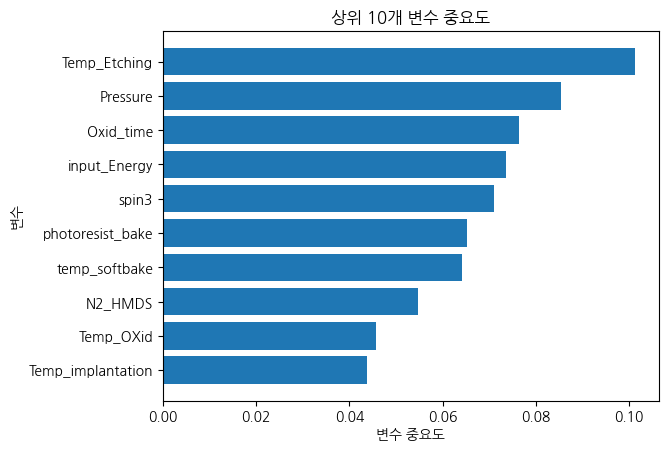

In [20]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = best_grad.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
top_10_importance = df_importance.nlargest(10, "Importance")

# 시각화
coordinates = range(len(top_10_importance))
plt.barh(y=coordinates[::-1], width=top_10_importance["Importance"])
plt.yticks(coordinates[::-1], top_10_importance["Feature"], fontsize=10)
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.title("상위 10개 변수 중요도")
plt.show()

### SMOTE

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [22]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_train_x, df_train_y)
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(df_test_x)
print(classification_report(df_test_y, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       472
         1.0       0.51      0.56      0.53        36

    accuracy                           0.93       508
   macro avg       0.74      0.76      0.75       508
weighted avg       0.93      0.93      0.93       508



In [23]:
# estimator = GradientBoostingClassifier( random_state=1234)
# # 구하고자 하는 parameter와 범위
# param_grid = {"learning_rate": [0.1, 0.3, 0.5, 0.7, 1],
#               "max_depth": list(range(3,13)),
#               "min_samples_leaf": [5,10,15,20,25,30],
#              'n_estimators' : [100,150,200,250,300]}
# # 정확도가 높은 최적 parameter 찾기
# grid_gb = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs = -1)
# grid_gb.fit(X_resampled, y_resampled)
# print("best estimator model: \n{}".format(grid_gb.best_estimator_))
# print("\nbest parameter: \n{}".format(grid_gb.best_params_))
# print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

In [24]:
best_grad= GradientBoostingClassifier(learning_rate=0.3, max_depth=9, min_samples_leaf=30, n_estimators=200,
                           random_state=123)
best_grad.fit(X_resampled, y_resampled)

y_pred = best_grad.predict(df_test_x)
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred))

Confusion matrix: 
[[467   5]
 [ 10  26]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       472
         1.0       0.84      0.72      0.78        36

    accuracy                           0.97       508
   macro avg       0.91      0.86      0.88       508
weighted avg       0.97      0.97      0.97       508



In [40]:
df_raw_x['Pressure'] = np.random.uniform(0.18, 0.192+0.003482*1000, size=len(df))
df_raw_x['Temp_OXid'] = np.random.uniform(1294.578413-15.574712*1000, 1348.471208, size=len(df))
df_raw_x['temp_softbake'] = np.random.uniform(95.281-0.392641*1000, 96.653, size=len(df))
df_raw_x['photoresist_bake'] = np.random.uniform(5.135-0.030536*1000, 5.239, size=len(df))
df_raw_x['Temp_Etching'] = np.random.uniform(68.150, 68.920+0.223740*1000, size=len(df))
df_raw_x['Temp_implantation'] = np.random.uniform(97.744, 100.253+0.713040*1000, size=len(df))
df_raw_x['spin1'] = np.random.uniform(492.2, 494+0.513626*1000, size=len(df))
df_raw_x['spin3'] = np.random.uniform(5172.1-6.260140*1000, 5194.134, size=len(df))
df_raw_x['Source_Power'] = np.random.uniform(49.342, 49.979+0.180593*1000, size=len(df))
df_raw_x['temp_HMDS_bake'] = np.random.uniform(205.3-1.200229*1000, 209.5, size=len(df))
df_raw_x['ppm'] = np.random.uniform(45.89-1.164920*1000, 49.91, size=len(df))
df_raw_x['RTA_Temp'] = np.random.uniform(148, 149+0.293984*1000, size=len(df))

In [41]:
# df_raw_x['Pressure'] = np.random.uniform(0.18, 0.192+0.003482*10, size=len(df))
# df_raw_x['Temp_OXid'] = np.random.uniform(1294.578413-15.574712*10, 1348.471208, size=len(df))
# df_raw_x['temp_softbake'] = np.random.uniform(95.281-0.392641*10, 96.653, size=len(df))
# df_raw_x['photoresist_bake'] = np.random.uniform(5.135-0.030536*10, 5.239, size=len(df))
# df_raw_x['Temp_Etching'] = np.random.uniform(68.150, 68.920+0.223740*10, size=len(df))
# df_raw_x['Temp_implantation'] = np.random.uniform(97.744, 100.253+0.713040*10, size=len(df))
# df_raw_x['spin1'] = np.random.uniform(492.2, 494+0.513626*10, size=len(df))
# df_raw_x['spin3'] = np.random.uniform(5172.1-6.260140*10, 5194.134, size=len(df))
# df_raw_x['Source_Power'] = np.random.uniform(49.342, 49.979+0.180593*10, size=len(df))
# df_raw_x['temp_HMDS_bake'] = np.random.uniform(205.3-1.200229*10, 209.5, size=len(df))
# df_raw_x['ppm'] = np.random.uniform(45.89-1.164920*10, 49.91, size=len(df))
# df_raw_x['RTA_Temp'] = np.random.uniform(148, 149+0.293984*10, size=len(df))

In [42]:
# df_raw_x['Pressure'] = np.random.uniform(0.18, 0.192, size=len(df))
# df_raw_x['Temp_OXid'] = np.random.uniform(1294.578413, 1348.471208, size=len(df))
# df_raw_x['temp_softbake'] = np.random.uniform(95.281, 96.653, size=len(df))
# df_raw_x['photoresist_bake'] = np.random.uniform(5.135, 5.239, size=len(df))
# # df_raw_x['Temp_Etching'] = np.random.uniform(68.150, 68.920, size=len(df))
# # df_raw_x['Temp_implantation'] = np.random.uniform(97.744, 100.253, size=len(df))
# # df_raw_x['spin1'] = np.random.uniform(492.2, 494, size=len(df))
# # df_raw_x['spin3'] = np.random.uniform(5172.1, 5194.134, size=len(df))
# # df_raw_x['Source_Power'] = np.random.uniform(49.342, 49.979, size=len(df))
# # df_raw_x['temp_HMDS_bake'] = np.random.uniform(205.3, 209.5, size=len(df))
# # df_raw_x['ppm'] = np.random.uniform(45.89, 49.91, size=len(df))
# # df_raw_x['RTA_Temp'] = np.random.uniform(148, 149, size=len(df))

In [43]:
best_grad = GradientBoostingClassifier(learning_rate=0.3, max_depth=9, min_samples_leaf=30, n_estimators=200, random_state=123)

best_grad.fit(df_train_x, df_train_y)


y_pred = best_grad.predict(df_raw_x)
print(y_pred)

[0. 0. 0. ... 0. 0. 0.]


In [44]:
# y_pred에서 0의 개수
num_zeros = np.sum(y_pred == 0)

# y_pred에서 1의 개수
num_ones = np.sum(y_pred == 1)

print(f"Number of 0's: {num_zeros}")
print(f"Number of 1's: {num_ones}")


Number of 0's: 1592
Number of 1's: 101


In [30]:
df_raw_x[['Pressure', 'Temp_OXid', 'temp_softbake', 'photoresist_bake', 'Temp_Etching',
           'Temp_implantation', 'spin1', 'spin3', 'Source_Power', 'temp_HMDS_bake', 'ppm', 'RTA_Temp']].describe()

,Pressure,Temp_OXid,temp_softbake,photoresist_bake,Temp_Etching,Temp_implantation,spin1,spin3,Source_Power,temp_HMDS_bake,ppm,RTA_Temp
count,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000,1693.000000
mean,0.203752,1243.468879,93.988455,5.036087,71.154075,103.163752,500.815121,5019.106823,51.241203,200.534802,33.389557,154.700532
std,0.013509,60.598882,1.561482,0.118555,0.792881,1.652589,3.001083,68.803928,0.639700,2.874814,8.076413,2.404828
min,0.180012,1138.975081,91.355051,4.830025,68.150000,97.744000,492.196000,4814.620000,49.342000,191.209000,21.070000,148.000000
25%,0.191872,1190.232601,92.649200,4.931953,70.754000,102.064000,498.878000,4970.858000,50.806000,198.351000,26.060000,153.000000
50%,0.204147,1243.790503,93.911188,5.035994,71.211000,103.298000,501.048000,5020.190000,51.247000,200.542000,33.590000,155.000000
75%,0.215673,1297.119713,95.410158,5.139482,71.615000,104.322000,503.123000,5072.106000,51.699000,202.786000,39.510000,156.000000
max,0.226813,1348.381307,96.652671,5.238960,73.081000,107.376000,509.055000,5194.134000,53.272000,209.521000,49.910000,162.000000


In [31]:
# df_raw_x['Pressure'] = np.random.uniform(0.18, 0.192+0.003482*10, size=len(df))
# df_raw_x['Temp_OXid'] = np.random.uniform(1294.578413-15.574712*10, 1348.471208, size=len(df))
# df_raw_x['temp_softbake'] = np.random.uniform(95.281-0.392641*10, 96.653, size=len(df))
# df_raw_x['photoresist_bake'] = np.random.uniform(5.135-0.030536*10, 5.239, size=len(df))
# df_raw_x['Temp_Etching'] = np.random.uniform(68.150, 68.920+0.223740*10, size=len(df))
# df_raw_x['Temp_implantation'] = np.random.uniform(97.744, 100.253+0.713040*10, size=len(df))
# df_raw_x['spin1'] = np.random.uniform(492.2, 494+0.513626*10, size=len(df))
# df_raw_x['spin3'] = np.random.uniform(5172.1-6.260140*10, 5194.134, size=len(df))
# df_raw_x['Source_Power'] = np.random.uniform(49.342, 49.979+0.180593*10, size=len(df))
# df_raw_x['temp_HMDS_bake'] = np.random.uniform(205.3-1.200229*10, 209.5, size=len(df))
# df_raw_x['ppm'] = np.random.uniform(45.89-1.164920*10, 49.91, size=len(df))
# df_raw_x['RTA_Temp'] = np.random.uniform(148, 149+0.293984*10, size=len(df))

In [32]:
# df_raw_x['Pressure'] = np.random.uniform(0.18, 0.192+0.003482*10, size=len(df))
# df_raw_x['Temp_OXid'] = np.random.uniform(1294.578413-15.574712*10, 1348.471208, size=len(df))
# df_raw_x['temp_softbake'] = np.random.uniform(95.281-0.392641*10, 96.653, size=len(df))
# df_raw_x['photoresist_bake'] = np.random.uniform(5.135-0.030536*10, 5.239, size=len(df))
# # df_raw_x['Temp_Etching'] = np.random.uniform(68.150, 68.920+0.223740*10, size=len(df))
# # df_raw_x['Temp_implantation'] = np.random.uniform(97.744, 100.253+0.713040*10, size=len(df))
# # df_raw_x['spin1'] = np.random.uniform(492.2, 494+0.513626*10, size=len(df))
# # df_raw_x['spin3'] = np.random.uniform(5172.1-6.260140*10, 5194.134, size=len(df))
# # df_raw_x['Source_Power'] = np.random.uniform(49.342, 49.979+0.180593*10, size=len(df))
# # df_raw_x['temp_HMDS_bake'] = np.random.uniform(205.3-1.200229*10, 209.5, size=len(df))
# # df_raw_x['ppm'] = np.random.uniform(45.89-1.164920*10, 49.91, size=len(df))
# # df_raw_x['RTA_Temp'] = np.random.uniform(148, 149+0.293984*10, size=len(df))

In [33]:
# best_grad = GradientBoostingClassifier(learning_rate=0.3, max_depth=9, min_samples_leaf=30, n_estimators=200, random_state=123)

# best_grad.fit(df_train_x, df_train_y)


# y_pred = best_grad.predict(df_raw_x)
# print(y_pred)

In [34]:
# # y_pred에서 0의 개수
# num_zeros = np.sum(y_pred == 0)

# # y_pred에서 1의 개수
# num_ones = np.sum(y_pred == 1)

# print(f"Number of 0's: {num_zeros}")
# print(f"Number of 1's: {num_ones}")